In [ ]:
!mamba install matplotlib torchvision tensorboardX libpng imageio jpeg -y


In [15]:
from IPython import display
from utils import Logger, imageRow
import torch
import matplotlib.pyplot as plt
import random
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torchmetrics import MeanSquaredError
import collections
import imageio
import json

In [16]:
DATA_FOLDER = './EMNIST'
logger = Logger(model_name='emnist_VGAN', data_name='EMNIST')

### Load and transform data

In [17]:
def emnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5]),
         
         # rotate and flip the images
         transforms.RandomRotation((-90,-90)),
         transforms.RandomHorizontalFlip(p=1),
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.EMNIST(root=out_dir, split="balanced", train=True, transform=compose, download=True)

In [18]:
data = emnist_data()

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)

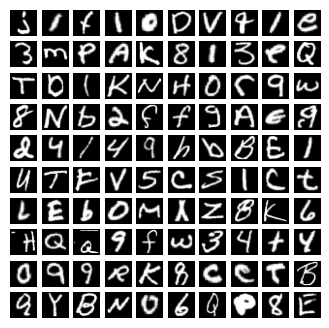

In [19]:
# visualize transformed training data
train_features = next(iter(data_loader))

figure = plt.figure(figsize=(4, 4))
cols, rows = 10, 10
for i in range(0, cols * rows):    
    img  = train_features[0][i]
    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

### Networks

In [20]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(-1, 1, 28, 28)

In [21]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Training

In [ ]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

# restart training from checkpoint
# discriminator.load_state_dict(torch.load('data/models/emnist_VGAN/EMNIST/D_epoch_199'))
# generator.load_state_dict(torch.load('data/models/emnist_VGAN/EMNIST/G_epoch_199'))


if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

num_test_samples = 16
test_noise = noise(num_test_samples)

for epoch in range(98, num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

### Inversion: Search for ideal images

In [ ]:
# collect labeled EMNIST
compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5]),
         
         # rotate and flip the images
         transforms.RandomRotation((-90,-90)),
         transforms.RandomHorizontalFlip(p=1),
        ])

data_labeled = datasets.EMNIST(root='CATEGORIZED', split="byclass", train=True, transform=compose, download=True)


chars = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

# load the latest weights
generator = GeneratorNet()
generator.load_state_dict(torch.load('data/models/emnist_VGAN/EMNIST/G_epoch_199'))
# non-training mode
generator.eval()


# collect real images ordered by label
grid_size = 62
data_by_label = [None] * grid_size

# increase this to start at a different point in the training data
# this gives a different set of real images
i = 5000
while None in data_by_label:
    datum = data_labeled[i]
    charIndex = datum[1]
    image = datum[0]
    
    if data_by_label[charIndex] == None:
        data_by_label[charIndex] = image
        
    i += 1


# optimize an input tensor to match a target image
mean_squared_error = MeanSquaredError()

def inversion_search(target_image, generator, steps=100, rate=0.01, verbose=False):
    output_sequence = []
    
    input = torch.zeros(100).requires_grad_()
    
    if verbose:
        print('optimizing...')
    
    for i in range(steps):
        output = generator(input)
        loss = mean_squared_error(output, target_image)
        output_sequence.append(output)
        
        loss.backward()
        
        with torch.no_grad(): 
            for j in range(len(input)):
                input[j] = torch.clamp(input[j] - input.grad[j] * rate, -1, 1)
                
        if verbose and i % 100 == 0:
            print(loss.tolist())
            
    return [input, output_sequence]


# for each character, collect final found input
# also collect output sequence for animation
opt_steps = 2000
animation_by_label = []
found_coord_by_label = []

for i, realImage in enumerate(data_by_label):
    result = inversion_search(torch.flatten(realImage), generator, opt_steps, 0.01)
    final_input = result[0]
    opt_images = result[1]
    
    animation_by_label.append(opt_images)
    found_coord_by_label.append(final_input)
   
        
# display the real images
figure1 = plt.figure(figsize=[15,15])
for i, datum in enumerate(data_by_label):
    img = datum
    charIndex = i
    
    ax = figure1.add_subplot(10, 10, i + 1)
    ax.set_title(f'{charIndex} - {chars[charIndex]}',{'fontsize': 7})
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.savefig('pics/reals.png', dpi=20, bbox_inches="tight")
plt.show()


# display the fake images
figure2 = plt.figure(figsize=[15,15])
for charIndex, outputSequence in enumerate(animation_by_label):
    output = outputSequence[-1]
    reshaped = output.detach().numpy().reshape((28,28))
    ax = figure2.add_subplot(10, 10, charIndex + 1)
    ax.set_title(f'{charIndex} - {chars[charIndex]}' ,{'fontsize': 7})
    plt.axis("off")
    plt.imshow(reshaped.squeeze(), cmap="gray")
    
plt.savefig('pics/fakes.png', dpi=20, bbox_inches="tight")
plt.show()

# write map to JSON file
coord_map = {}
for i, coords in enumerate(found_coord_by_label):
    coord_map[chars[i]] = coords.tolist()
    
json_object = json.dumps(coord_map, indent=2)

with open("addresses.json", "w") as outfile:
    outfile.write(json_object)

### Animate Inversion Search

In [2]:
# make a plot every 10 steps
for i in range(opt_steps):
    if i % 10 == 0:
    
        fig = plt.figure(figsize=[35,35])
    
        for charIndex, outputSequence in enumerate(animation_by_label):
            reshaped = outputSequence[i].detach().numpy().reshape((28,28))
    
            ax = fig.add_subplot(10, 10, charIndex + 1)
            ax.set_title(f'{charIndex} - {chars[charIndex]}' ,{'fontsize': 30})
            plt.axis("off")
            plt.imshow(reshaped.squeeze(), cmap="gray")

        plt.savefig(f'animation/grid_{str(i).zfill(4)}.png', dpi=20, bbox_inches="tight")
        plt.close()
        

# combine frames into animation
import imageio

frames = []
for i in range(int(1600 / 10)):
    image = imageio.v2.imread(f'animation/grid_{str(i * 10).zfill(4)}.png')
    frames.append(image)
    
imageio.mimsave('pics/search.gif', frames, fps = 5)
        

### Export for ONNX

In [ ]:
torch.onnx.export(
    generator,
	# properly-shaped random input for recording execution
    torch.randn(1, 100),
    "vgan_emnist.onnx",
    verbose=False,
    input_names=["z"],
    output_names=["img"],
    export_params=True,